# Image Classification with Data Augmentation
## Which helps more: Extra Training Images, or Data Augmentation?
### Jesse Galef

### Overview:

*   More training examples help out-of-sample generalization
*  Collecting more training examples is expensive
*  Approximate 'new' training examples by applying image transformations to existing samples
  * Flip L-R
  * Rotate
  * Translate L-R, U-D
  * Adjust Brightness
  * Adjust Contrast
  * Sharpen/Blur
*  Pick a random transformation & random magnitude for each image during training, to simulate additional samples
*  Compare the effect of this augmentation to using a larger training set
  

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline


In [0]:
from scipy import ndimage
from skimage.exposure import adjust_gamma, adjust_sigmoid

In [0]:
from keras.layers import Input, Conv2D, Dense, Flatten, Reshape, MaxPool2D
from keras.utils import to_categorical
from keras.models import Model
from keras.optimizers import rmsprop, Adam

In [0]:
from keras.datasets import cifar10
(X_full, y_full), (X_test, y_test) = cifar10.load_data()
imageClasses = ["airplane",
"automobile",
"bird",
"cat",
"deer",
"dog",
"frog",
"horse",
"ship",
"truck"]

In [0]:
# Divide the data into training and validation sets

from sklearn.model_selection import train_test_split
X, X_val, y, y_val = train_test_split(X_full, y_full, shuffle=True, 
                                      random_state=42, test_size=.2)

## Look at our images

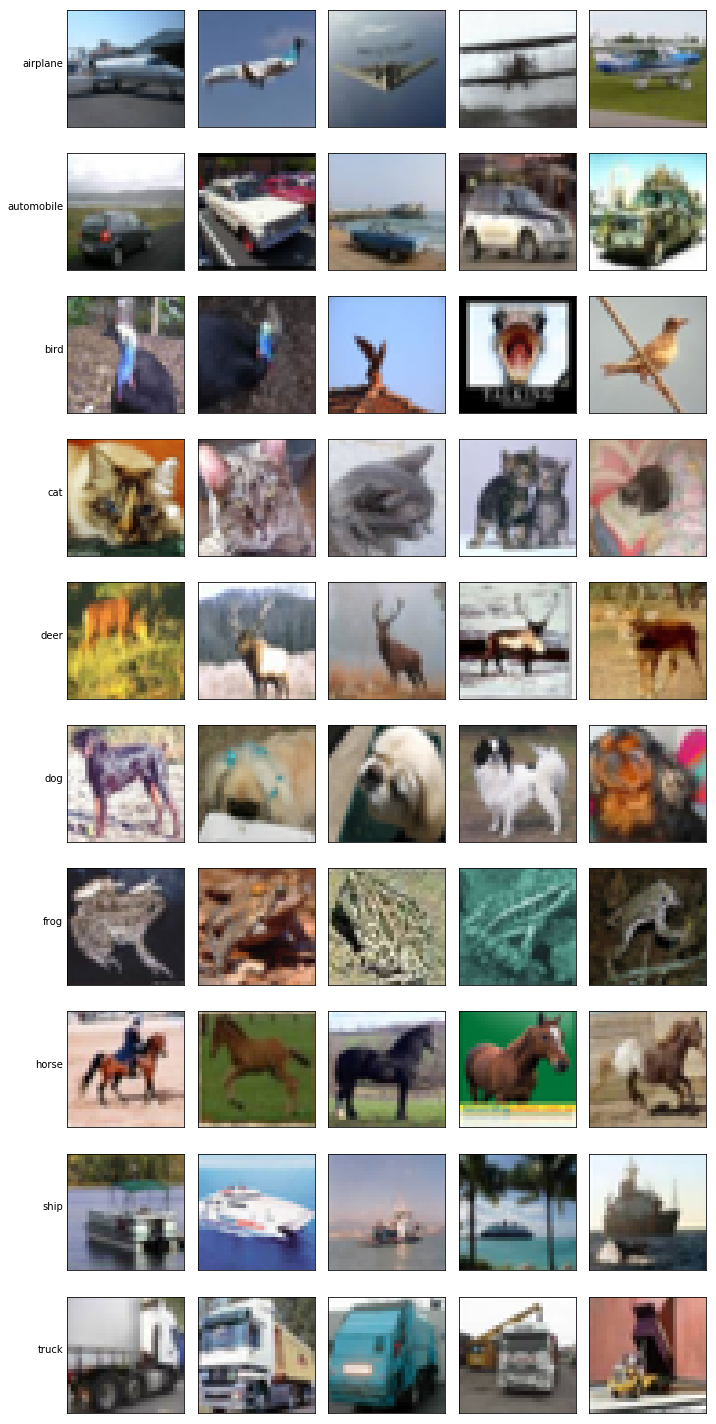

In [13]:
plt.figure(figsize=[10,20])
plt.text(1,0, '\n'.join(imageClasses))

for i in range(10):

    for j in range(5):
        plt.subplot(10,5, 5*i+j+1)

        plt.imshow(X[y[:,0]==i][j])
        plt.xticks([])
        plt.yticks([])
        if j==0:
            plt.ylabel(imageClasses[i], rotation=0, ha='right')

plt.tight_layout()

## Design our image transforms

In [0]:
identity = lambda x,z: x
rotate = lambda x,z: ndimage.rotate(x, (z-.5)*120, reshape=False) #-60 to 60
flip_lr = lambda x,z: x if abs(z-.5) <=.25 else np.fliplr(x)

def translate_lr(x,z, max_percent=.2):
    new_x = np.zeros_like(x)
    img_width = x.shape[1]
    shift = int(img_width * max_percent * (z-.5) * 2)
    if shift < 0:
        #shift left
        new_x[:,:shift] = x[:,-shift:]
    elif shift > 0:
        # shift right
        new_x[:,shift:] = x[:,:-shift]
    else:
        new_x = x
    return new_x    

def translate_ud(x,z, max_percent=.2):
    new_x = np.zeros_like(x)
    img_height = x.shape[0]
    shift = int(img_height* max_percent * (z-.5) * 2)
    if shift < 0:
        #shift up, shift is negative
        new_x[:shift] = x[-shift:]
    elif shift > 0:
        # shift down, shift is positive
        new_x[shift:] = x[:-shift]
    else:
        new_x = x
    return new_x    

def sharpen(x,z):
    filter_blurred_x = ndimage.gaussian_filter(x, 1)
    alpha = (.5-z) * .5
    
    # z of 0 is blurred, alpha is -.5
    sharpened = x + alpha * (x - filter_blurred_x) / (1.+alpha)

    min_val = sharpened.min()
    if min_val < 0:
        sharpened = sharpened - min_val
        
    max_val = sharpened.max()
    if max_val > 255:
        sharpened = 255. * (sharpened / max_val.astype(float))
        
    sharpened = np.clip(sharpened, 0, 255.)
    return sharpened.astype(int)


sigmoid = lambda x, z: adjust_sigmoid(x, gain=1+(z*10))
gamma = lambda x, z: adjust_gamma(x, gamma=.25+(z*1.5))

operations = [identity, rotate, flip_lr, translate_lr, 
                            translate_ud, sharpen, sigmoid, gamma]
n_ops = len(operations)

operation_names = ['identity', 'rotate', 'flip_lr', 'translate_lr', 
                            'translate_ud', 'sharpen', 'adjust_sigmoid', 'adjust_gamma']


## Visualize our transformations

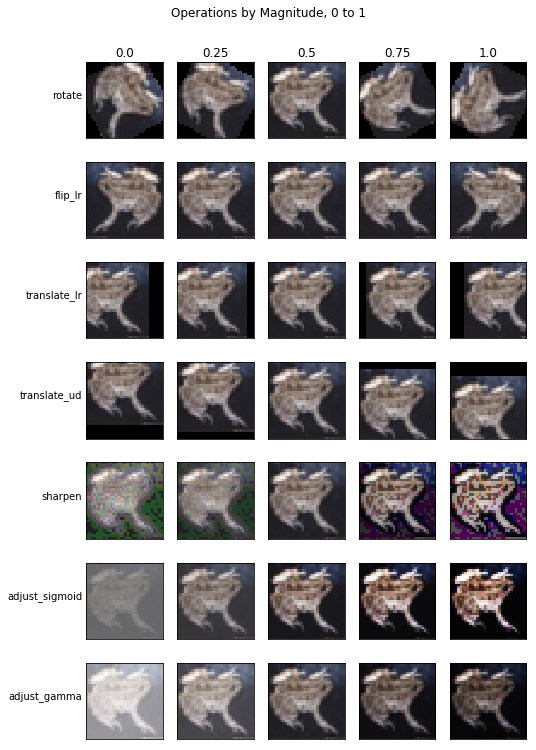

In [15]:
n=1
image_id = 0
n_values = 5
display_size = 1.5
n_ops = len(operations)

plt.figure(figsize=[display_size*n_values,display_size*n_ops])


for j, op in enumerate(operations[1:]):
    for i in range(n_values):
        plt.subplot(n_ops,n_values,i+1+(j*n_values))
        if j==0:
            plt.title(i/(n_values-1))
        if i==0:
            plt.ylabel(operation_names[j+1], rotation=0, ha='right')
        plt.imshow(op(X[image_id], i/(n_values-1))) 
        plt.yticks([])
        plt.xticks([])
plt.suptitle('Operations by Magnitude, 0 to 1')        
plt.tight_layout(rect=[0,0,1,.95], pad=1.01)


## Construct & Train Neural Net Classifier


In [0]:

def get_new_model(X,y, optimizer=Adam(lr=.0001)):
    """
    Passed arrays X, y and an optimizer
    
    X[n_images, height, width, channels] 
    y[n_images, 1] or y[n_images, n_classes]
    optimizer Keras object, default is rmsprop
    
    returns a image classification neural net
    based off a simplified version of the one in Keras'
    sample
    
    """
    if len(y.shape) == 1 or y.shape[1] == 1:
        n_classes = to_categorical(y).shape[1]
    else:
        n_classes = y.shape[1]
        
    reused_params = {'kernel_size': [3,3], 'padding': 'same',
                     'activation': 'relu', 'kernel_initializer': 'RandomNormal'}

    image_input = Input(list(X[0].shape), name='imageInput')
    activity = Conv2D(filters=32, **reused_params)(image_input)
    activity = Conv2D(filters=32, **reused_params)(activity)
    activity = MaxPool2D(padding='same')(activity)

    activity = Conv2D(filters=64, **reused_params)(activity)
    activity = Conv2D(filters=64, **reused_params)(activity)
    activity = MaxPool2D(padding='same')(activity)

    activity = Flatten()(activity)
    activity = Dense(256, activation='relu')(activity)
    output = Dense(n_classes, activation='softmax')(activity)

    model = Model(image_input, output)
    model.compile(optimizer, 'categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [0]:
def data_generator(X, y, operations=None, batch_size=1, verbose=0):
    """
    Yields batches of transformed X and y
    Each image in X gets a random operation in operations,
    with a magnitude selected uniformly at random between 0 and 1
    
    
    Passed:
      
    X: array[n_images, ...]
    y: array[n_images, ...]
    operations: list of functions that take (image, magnitude)
    batch_size: int
    
    """
    while True:
        ix = np.arange(len(X))
        np.random.shuffle(ix)
        for i in range(len(X) // batch_size):
            if verbose > 0:
                print ("next batch")
            _ix = ix[i*batch_size:(i+1)*batch_size]
            _X = np.array(X[_ix], copy=True)
            _y = y[_ix]
            for j, x in enumerate(_X):
                if operations is not None:
                    op = np.random.choice(operations)
                    mag = np.random.rand()
                    _X[j] = op(x, mag)
            yield _X, _y

In [0]:
            
def train_model(X, y, X_val, y_val, epochs=30, batch=128, 
              operations=[(lambda x, z: x)], **fit_args):
    """
    Builds and trains a model with data augmentation 
    
    Creates a data generator to alter the training images using a uniform
    random chance of applying each operation passed in the operations list,
    and a random uniform magnitude between 0 and 1.

    X: Training images, [n_images, height, width, channels]
        If X is greyscale and has 3 dimensions, a 4th will be added
    y: Training labels, one-dimensional (not one-hot encoded)
    
    epochs: How many epochs of n_train images to train for
    batch: What size batch to use in fit
    
    operations: List of (function, concentration) pairs
        Where the function takes a 3-dimensional ndarray [nRows, nCols, nChannels]
        and concentration defines a beta distribution for magnitude of transform
        Returns the transformed image
    
    """
    
    if len(X.shape) == 3:
        # If the images are greyscale, add a dimension
        X = X[...,np.newaxis]
        X_val = X_val[...,np.newaxis]
    np.random.seed(42)
    model = get_new_model(X, y, 
                          optimizer=Adam(lr=1e-4))
    
    generator = data_generator(X, to_categorical(y), 
                               operations,
                               batch_size=batch)
       
    model.fit_generator(generator,
                         steps_per_epoch = X.shape[0] // batch,
                         epochs=epochs,
                         use_multiprocessing=True,
                         validation_data=[X_val, to_categorical(y_val)],
                         **fit_args)
    
    return model

## Train our models on 10k, 20k, and 40k images
## Both with and without data augmentation

In [0]:
#
# I ran this and then removed the verbose reporting
#

epochs=200
batch=128

sizes = [10000,20000,40000]
transforms = [(None, "Unaugmented"), (operations, "Augmented")]

models = {}

for ops, name in transforms:
    for size in sizes:
        model_name = name+"_"+str(size)
        print ('starting '+model_name)
        models[model_name] = train_model(X[:size],y[:size],X_val,y_val, 
                                        epochs=epochs,
                                        batch=batch, verbose=0,
                                        operations=ops)
        print ('done '+model_name)

## Visualize the results!

In [0]:
import pandas as pd
rows = []
for model_name in models:
    row = {}
    predictions = models[model_name].predict(X_val).argmax(1)
    row['score'] = (predictions == y_val.flatten()).mean()
    row['augmented'] = model_name[:2] == 'Au'
    row['n_train'] = int(model_name[-5:])
    rows.append(row)
final = pd.DataFrame(rows)


In [35]:
final

,augmented,n_train,score
0,False,10000,0.5732
1,False,20000,0.6295
2,False,40000,0.6929
3,True,10000,0.6843
4,True,20000,0.7377
5,True,40000,0.7995


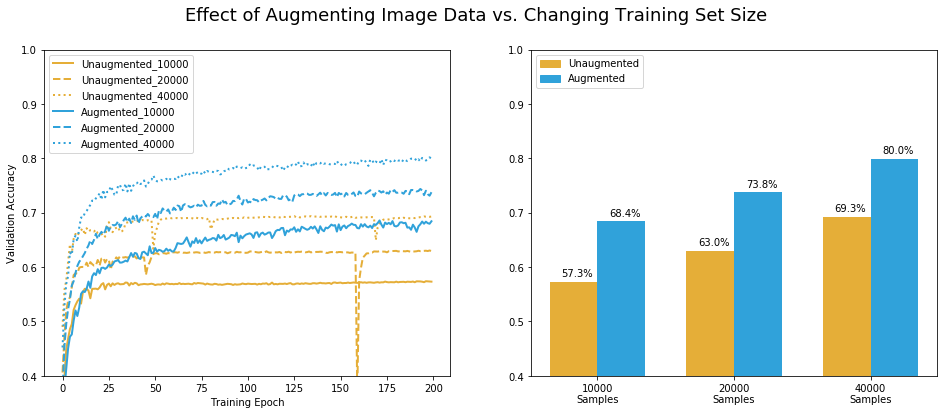

In [41]:
plt.figure(figsize=[16,6])
ylim = [.4, 1]

plt.subplot(1,2,1)
colors = {'Un': '#e5ae38', 'Au': '#30a2da'}
styles = {'10000': 'solid', '20000': 'dashed', '40000':'dotted'}
for model_name in models:
    style = styles[model_name[-5:]]
    color = colors[model_name[:2]]
    plt.plot(models[model_name].history.history['val_acc'],
           linestyle=style, linewidth=2,
           color=color, label=model_name)
plt.legend(loc=2)
plt.ylim(ylim)
plt.xlabel('Training Epoch')
plt.ylabel('Validation Accuracy')

plt.subplot(1,2,2)
bar_width=.35
plt.bar(x=np.arange(3), height=final[final.augmented==False].score, 
        width=bar_width, color=colors['Un'])
for i, score in enumerate(final[final.augmented==False].score):
    plt.text(i-bar_width/4., score+.01, str(np.round(score*1000)/10.)+'%')
for i, score in enumerate(final[final.augmented==True].score):
    plt.text(i+(.75*bar_width), score+.01, str(np.round(score*1000)/10.)+'%')

    
plt.bar(x=np.arange(3)+bar_width, height=final[final.augmented==True].score, 
        width=bar_width, color=colors['Au'])  

plt.xticks(np.arange(3)+bar_width/2., 
             ['10000\nSamples', '20000\nSamples', '40000\nSamples'])
plt.ylim(ylim)
plt.suptitle('Effect of Augmenting Image Data vs. Changing Training Set Size',
            fontsize=18)

import matplotlib.patches as mpatches

unaug_patch = mpatches.Patch(color=colors['Un'], label='Unaugmented')
aug_patch = mpatches.Patch(color=colors['Au'], label='Augmented')
_=plt.legend(handles=[unaug_patch, aug_patch], loc=2)

Text(0, 0.5, 'Validation Accuracy')

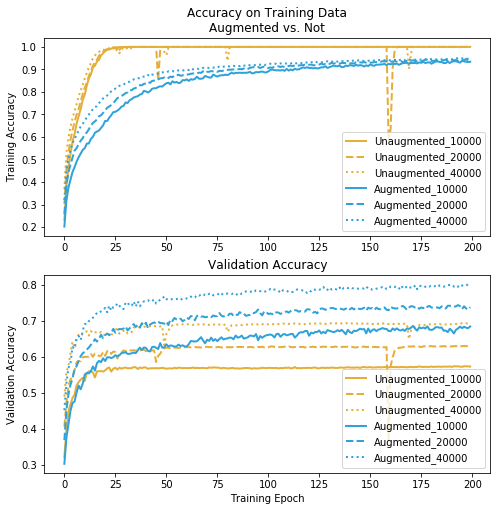

In [56]:
plt.figure(figsize=[8,8])
plt.subplot(2,1,1)
plt.title('Accuracy on Training Data\nAugmented vs. Not')
colors = {'Un': '#e5ae38', 'Au': '#30a2da'}
styles = {'10000': 'solid', '20000': 'dashed', '40000':'dotted'}
for model_name in models:
    style = styles[model_name[-5:]]
    color = colors[model_name[:2]]
    plt.plot(models[model_name].history.history['acc'],
           linestyle=style, linewidth=2,
           color=color, label=model_name)
plt.legend(loc=4)
plt.ylabel('Training Accuracy')
# plt.ylim([0,1.1])


plt.subplot(2,1,2)
colors = {'Un': '#e5ae38', 'Au': '#30a2da'}
styles = {'10000': 'solid', '20000': 'dashed', '40000':'dotted'}
for model_name in models:
    style = styles[model_name[-5:]]
    color = colors[model_name[:2]]
    plt.plot(models[model_name].history.history['val_acc'],
           linestyle=style, linewidth=2,
           color=color, label=model_name)
plt.legend(loc=4)
# plt.ylim([0,1.1])
plt.title('Validation Accuracy')
plt.xlabel('Training Epoch')
plt.ylabel('Validation Accuracy')

### By the 25th epoch or so, the unaugmented models had reached 100% accuracy on the training data (which does not generalize to unseen samples) while the augmented models steadily improved over time

## Finally, compare the models' performance on the test data:

In [37]:
for model_name in models:
    pred = models[model_name].predict(X_test).argmax(1)
    print (model_name, ": ", (pred==y_test.flatten()).mean())


Unaugmented_10000 :  0.575
Unaugmented_20000 :  0.6353
Unaugmented_40000 :  0.6878
Augmented_10000 :  0.6793
Augmented_20000 :  0.7344
Augmented_40000 :  0.7918


### Applying our image augmentation was almost as effective as using four times as many training images! 


## Final Thoughts:


* This implementation was fairly basic -- simple neural net, uniform random magnitude, single image transform at a time... And yet it still performed well

* Google Brain's AutoAugment took things to the next level -- applying multiple transformations in a row and using reinforcement learning to identify better combinations of operations and magnitudes.

* Even without the complexity of Google Brain's approach, I expect it would improve accuracy to learn a distribution of transformation magnitudes -- the extreme magnitudes are probably less helpful than those closer to the original image.